# Segmentation of selected solar corona structures

# Part 2/2: Segmentation of Active Regions


---


### Author: Bc. Ľubomír Lazor
### Supervisor: doc. Ing. Martin Sarnovský, PhD.
Department of Cybernetics and Artificial Intelligence, Faculty of Electrical Engineering and Informatics, Technical University of Košice, Košice, Slovakia


## Abstract
This thesis explores the use of deep learning for the automated segmentation of coronal holes (CHs) and active regions (ARs) in solar EUV images. These structures are key to understanding solar activity and predicting space weather. Building on the SCSS-Net model, a U-Net-based architecture, this work combines theoretical insights with practical modeling to assess performance of various configurations. The results show that deep learning can offer a reliable, scalable solution for the segmentation of solar structures driven by thoughtful data handling and model design.

---

### Disclaimer: this code is based on SCSS-Net

## Jupyter notebook – Segmentation of Active Regions
In the following, we present the data and Python methods used for analysis described in the thesis. Overview of the notebook:
1. Environment set-up
2. Dynamic data preparation with augmentations
3. Modeling
4. Evaluation and visualization

<font color="red">If you want to just evaluate or test data, use "U-net_AR_evaluation_only.ipynb" for ease of use<font>

# 1. Environment set-up

* Set-up the environment

In [ ]:
import sys, os
!pip install -r requirements.txt
sys.path.append('../scss-net/src')

* Import libraries

In [ ]:
import cv2
import zipfile
import glob
import numpy as np
import albumentations
from PIL import Image
import tensorflow as tf
from datetime import datetime
import matplotlib.pylab as plt
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image

import glob
from PIL import Image
import matplotlib.pylab as plt

from src.model_scss_net import scss_net
from src.metrics import dice_np, iou_np, dice, iou
from src.utils import plot_imgs, plot_metrics

* Import local utilities

In [ ]:
from src.model_scss_net import scss_net
from src.metrics import dice_np, iou_np, dice, iou
from src.utils import plot_imgs, plot_metrics

# 2. Dynamic data preparation with augmentations

*   Set global variables


In [ ]:
IMG_SIZE = 256  # Resize images to 256x256
BATCH_SIZE = 20 # set batch size
SEED = 42       # set seed for reproducibility
EPOCHS = 100    # Set number of epochs

MODEL_NAME = "ar_model" # Specify model name
MODEL_FILENAME = f"./{MODEL_NAME}_epoch{{epoch:02d}}.h5" # Dynamic naming of different epoch that are going to be saved during training process

* Load validation and training data (images and masks)

In [ ]:
imgs_valid = glob.glob("/data/AR/images_renamed/valid/*.png")
masks_valid = glob.glob("/data/AR/masks_renamed/valid/*.png")

print(f"Imgs number = {len(imgs_valid)}\nMasks number = {len(masks_valid)}")

In [ ]:
imgs_train = glob.glob("/data/AR/images_renamed/train/*.png")
masks_train = glob.glob("/data/AR/masks_renamed/train/*.png")

print(f"Imgs number = {len(imgs_train)}\nMasks number = {len(masks_train)}")

* Load, resize, and convert data to list of numpy arrays


In [ ]:
imgs_valid_list = []  # list of input images
masks_valid_list = [] # list of masks (annotations)

for image, mask in zip(imgs_valid, masks_valid):
    imgs_valid_list.append(np.array(Image.open(image).convert("L").resize((IMG_SIZE, IMG_SIZE))))
    masks_valid_list.append(np.array(Image.open(mask).convert("L").resize((IMG_SIZE, IMG_SIZE))))

In [ ]:
imgs_train_list = []  # list of input images
masks_train_list = [] # list of masks (annotations)

for image, mask in zip(imgs_train, masks_train):
    imgs_train_list.append(np.array(Image.open(image).convert("L").resize((IMG_SIZE, IMG_SIZE))))
    masks_train_list.append(np.array(Image.open(mask).convert("L").resize((IMG_SIZE, IMG_SIZE))))

* Normalize and reshape data

In [ ]:
# Data normalization: from (0; 255) to (0; 1)
x_valid = np.asarray(imgs_valid_list, dtype=np.float32)/255
y_valid = np.asarray(masks_valid_list, dtype=np.float32)/255

# Reshape to (n_imgs, height, width, channels)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1)
y_valid = y_valid.reshape(y_valid.shape[0], y_valid.shape[1], y_valid.shape[2], 1)

In [ ]:
# Data normalization: from (0; 255) to (0; 1)
x_train = np.asarray(imgs_train_list, dtype=np.float32)/255
y_train = np.asarray(masks_train_list, dtype=np.float32)/255

# Reshape to (n_imgs, height, width, channels)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], 1)



*   Add augumentations to train set




In [ ]:
# Define augmentations for the Train set
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.Rotate((-30, 30), p=0.5, border_mode=cv2.BORDER_REPLICATE),  
    albumentations.RandomGamma((100, 150), p=0.5),
    albumentations.RandomBrightnessContrast((0.0, 0.2), (0.0, 0.4), p=0.5),
    albumentations.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
    albumentations.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
    albumentations.GaussianBlur(blur_limit=(3, 5), p=0.3)
])

# Custom generator for images and masks
def data_generator(x_data, y_data, batch_size, augmentations):
    while True:
        # Shuffle indices if necessary
        indices = np.arange(len(x_data))
        np.random.shuffle(indices)

        # Generate batches
        for i in range(0, len(x_data), batch_size):
            batch_indices = indices[i:i+batch_size]
            x_batch = x_data[batch_indices]
            y_batch = y_data[batch_indices]
            
            # Apply augmentations
            augmented = [augmentations(image=x, mask=y) for x, y in zip(x_batch, y_batch)]
            x_aug = np.array([item['image'] for item in augmented])
            y_aug = np.array([item['mask'] for item in augmented])

            yield x_aug, y_aug

# Create the data generators
train_gen = data_generator(x_train, y_train, batch_size=BATCH_SIZE, augmentations=AUGMENTATIONS)

* Check if the shape of input is suitable for the training process of the model

In [ ]:
# input shape should be (256, 256, 1)
input_shape = x_train[0].shape
print(f"Input shape: {input_shape}\nTrain shape: {x_train.shape}  Val shape: {x_valid.shape}")

# 3. Modeling

* The SCSS-net model architecture is defined in **../src/model_scss_net.py**. Here is its visualization:

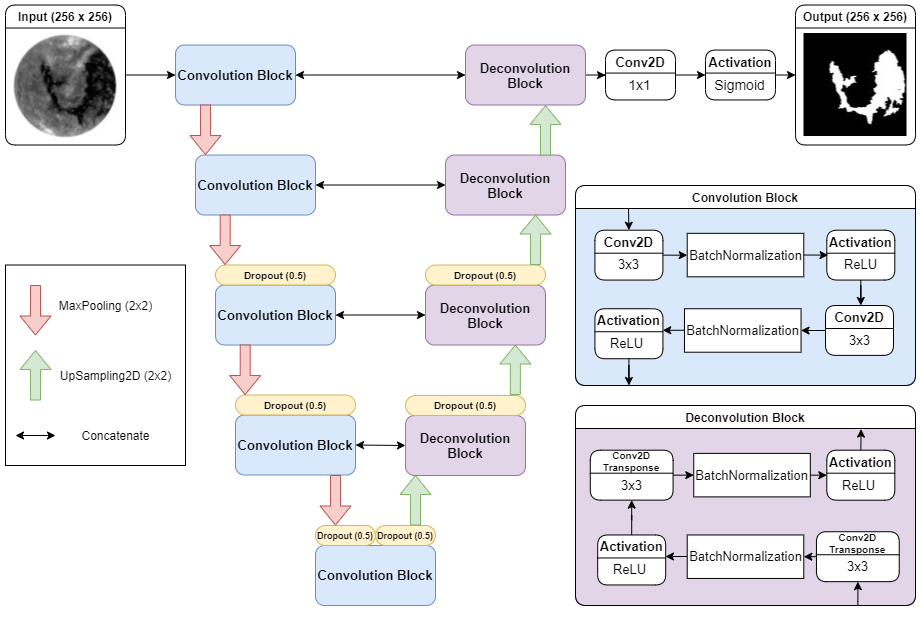

* Load the model with the parameters that were found to be optimal

In [ ]:
# Load model architecture with optimal parameteres
model = scss_net( 
    input_shape,
    filters=32,       
    layers=4,
    batch_norm=True,
    drop_prob=0.5)

# Compile model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",  
    metrics=[iou, dice])

# Set steps parameters acording to size of training set and size of batch
STEPS = x_train.shape[0] // BATCH_SIZE
SAVE_PERIOD = 5 # Save every 5th epoch

# Set callback for checkpointing
callback_checkpoint = ModelCheckpoint(
    MODEL_FILENAME,
    verbose=1,
    monitor="val_loss",
    save_best_only=False,  # Save all models, regardless of the validation loss score  
    save_weights_only=True,  # Save only weights, not full model  
    save_freq= int(SAVE_PERIOD * STEPS))

* Train the model (commented out so it is not accidentally started)

In [ ]:
# Train model
# history = model.fit(
#    train_gen,
#    steps_per_epoch=STEPS,
#    epochs=EPOCHS,
#    validation_data=(x_valid, y_valid),
#    callbacks=[callback_checkpoint],
#    verbose=2)

# Plot training history (Metrics and Loss)
# plot_metrics(history).show()

*If you encounter any problems during training, you can check out the "5. Extra tips (potential fixes)" section at the end of this notebook*

* Alternatively, the model could be loaded from an altredy trained one

In [ ]:
model.load_weights('models/ar_model.h5')

# 4. Evaluation and visualization

* Load, resize, convert, normalize and reshape training data (images and masks)

In [ ]:
imgs_test = glob.glob("/data/AR/images_renamed/test/*.png")
masks_test = glob.glob("/data/AR/masks_renamed/test/*.png")

print(f"Imgs number = {len(imgs_test)}\nMasks number = {len(masks_test)}")

# Load data and convert images to numpy array
imgs_test_list = []
masks_test_list = []
for image, mask in zip(imgs_test, masks_test):
    imgs_test_list.append(np.array(Image.open(image).convert("L").resize((IMG_SIZE, IMG_SIZE))))
    masks_test_list.append(np.array(Image.open(mask).convert("L").resize((IMG_SIZE, IMG_SIZE))))

# Normalization from (0; 255) to (0; 1)
x_test = np.asarray(imgs_test_list, dtype=np.float32)/255
y_test = np.asarray(masks_test_list, dtype=np.float32)/255

# Reshape to (n_imgs, height, width, channels)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2], 1)

* Predict new masks for test set and plot image sequence:

In [ ]:
y_pred = model.predict(x_test)  

* Visualization of the predicted segmentation: 
 - Image: input image 
 - Mask: ground truth (annotation mask)
 - Prediction: output of the model (predicted segmentation mask)
 - Overlay: predicted segmentation mask overlaid on the input image

In [ ]:
#n_imgs represents the number of images you want to be visualized
plot_imgs(imgs=x_test, masks=y_test, predictions=y_pred, n_imgs=5).show()

* Calculate averaged metrics over the test set without and with applied threshold

In [ ]:
y_pred_bin = np.where(y_pred > 0.5, 1, 0)  # Set threshold for predicted values, default number is set to 0.5

dice = np.round(dice_np(y_test, y_pred), 4)
iou_test = np.round(iou_np(y_test, y_pred), 4)

dice_tresh = np.round(dice_np(y_test, y_pred_bin), 4)
iou_test_tresh = np.round(iou_np(y_test, y_pred_bin), 4)

print(f"Test:\nDice: {dice} Dice_tresh: {dice_tresh}\n IoU: {iou_test} IoU_tresh: {iou_test_tresh}\n")

* Visualization of the predicted segmentation with threshold (converted to a binary prediction)

In [ ]:
#n_imgs represents the number of images you want to be visualized
plot_imgs(imgs=x_test, masks=y_test, predictions=y_pred_bin, n_imgs=5).show()

* Visualization of the time-series comparison of the solar disk area (%) with SPoCA on AIA and SUVI data

In [ ]:
# Extract dates from filenames
def extract_date_from_filename(filepath):
    basename = os.path.basename(filepath).replace(".png", "")
    match = re.search(r"(\d{4}_\d{2}_\d{2}T\d{2}_\d{2}_\d{2})", basename)
    if match:
        return datetime.strptime(match.group(1), "%Y_%m_%dT%H_%M_%S")
    else:
        raise ValueError(f"No valid timestamp found in filename: {basename}")

dates = [extract_date_from_filename(fp) for fp in imgs_test]

# Filter for selected year and month
selected_year = 2022  # Change as needed
selected_month = 9  # Change as needed
filtered_data = [(d, y_t, y_p, fp) for d, y_t, y_p, fp in zip(dates, y_test, y_pred_bin, imgs_test) if d.year == selected_year and d.month == selected_month]

if filtered_data:
    dates_filtered, seg_area_true_filtered, seg_area_pred_filtered, filenames_filtered = zip(*filtered_data)
else:
    dates_filtered, seg_area_true_filtered, seg_area_pred_filtered, filenames_filtered = [], [], [], []

# Function to calculate segmented area percentage
def compute_segmented_area(mask):
    return np.sum(mask) / (IMG_SIZE * IMG_SIZE) * 100  # Convert to percentage

# Convert segmented masks into percentage values
seg_area_true_filtered = [compute_segmented_area(mask) for mask in seg_area_true_filtered]
seg_area_pred_filtered = [compute_segmented_area(mask) for mask in seg_area_pred_filtered]

# Separate AIA and SUVI data
aia_data = [(d, y_t, y_p) for d, y_t, y_p, fp in zip(dates_filtered, seg_area_true_filtered, seg_area_pred_filtered, filenames_filtered) if "aia" in fp.lower()]
suvi_data = [(d, y_t, y_p) for d, y_t, y_p, fp in zip(dates_filtered, seg_area_true_filtered, seg_area_pred_filtered, filenames_filtered) if "suvi" in fp.lower()]
dates_aia_sorted, seg_area_true_aia_sorted, seg_area_pred_aia_sorted = zip(*sorted(aia_data)) if aia_data else ([], [], [])
dates_suvi_sorted, seg_area_true_suvi_sorted, seg_area_pred_suvi_sorted = zip(*sorted(suvi_data)) if suvi_data else ([], [], [])

In [ ]:
#Visualize the plots
plt.style.use('ggplot')
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
 
# AIA
axs[0].set_title(f"AIA segmentated area ({selected_year}, {selected_month:02d})")
axs[0].set_ylabel("Solar disc area [%]", fontsize=16)
axs[0].plot(dates_aia_sorted, seg_area_true_aia_sorted, label='True Mask (SPoCA)', color='dimgray')
axs[0].plot(dates_aia_sorted, seg_area_pred_aia_sorted, label='Predicted Mask (U-net Threshold A)', color='steelblue')
axs[0].fill_between(dates_aia_sorted, seg_area_true_aia_sorted, seg_area_pred_aia_sorted, color='whitesmoke')
axs[0].legend(loc='upper right', fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].set_ylim([0.8, 2.75])
 
# SUVI
axs[1].set_title(f"SUVI segmentated area ({selected_year}, {selected_month:02d})")
axs[1].set_xlabel("Date", fontsize=16)
axs[1].set_ylabel("Solar disc area [%]", fontsize=16)
axs[1].plot(dates_suvi_sorted, seg_area_true_suvi_sorted, label='True Mask (SPoCA)', color='dimgray')
axs[1].plot(dates_suvi_sorted, seg_area_pred_suvi_sorted, label='Predicted Mask (U-net Threshold A)', color='steelblue')
axs[1].fill_between(dates_suvi_sorted, seg_area_true_suvi_sorted, seg_area_pred_suvi_sorted, color='whitesmoke')
axs[1].legend(loc='upper right', fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[1].set_ylim([0, 3])

plt.tight_layout()
plt.show()

# 5. Extra tips (potential fixes)

* If the training process stops due to any reason, you can always resume it via the ModelCheckpoint function

In [ ]:
#set the last saved epoch as the checkpoint_path variable
checkpoint_path = "ar_model_epochXX.h5"

# change the MODEL_FILENAME to checkpoint_path like shown below
callback_checkpoint = ModelCheckpoint(
    checkpoint_path,
    verbose=1,
    monitor="val_loss",
    save_best_only=False,  # Save all models, regardless of the validation loss score  
    save_weights_only=True,  # Save only weights, not full model  
    save_freq= int(SAVE_PERIOD * STEPS))

* If the model is not saving properly after it should, you can use a parameter called "period". Note that the parameter is deprecated and may stop working any time

In [ ]:
# change the save_freq to period like shown below
callback_checkpoint = ModelCheckpoint(
    checkpoint_path,
    verbose=1,
    monitor="val_loss",
    save_best_only=False,  # Save all models, regardless of the validation loss score  
    save_weights_only=True,  # Save only weights, not full model  
    period=5)  # Save every 5 epochs

* If you have the weights and want to save the full model, you can do so here (the models included in this repository are saved as full models)

In [ ]:
# Save the full model
model.save('models/ar_model_name.h5')